In [84]:
%load_ext autoreload
%autoreload 2

import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim

import sys
sys.path.append('../src/')
from simple_transformer import MultilayerTransformer, initialize_weights, train_model
from markov_utilities import (
    calculate_sequence_probabilities,
    compute_myopic_entropy_from_MSP,
    epsilon_machine_to_graph,
    get_recurrent_subgraph,
    to_mixed_state_presentation,
    get_recurrent_subgraph,
    calculate_empirical_sequence_probabilities,
    create_transition_matrix
)
from visualization import visualize_graph_with_selective_offset
from processes import RRXORProcess, GoldenMeanProcess, ZeroOneRProcess, EvenProcess


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The Random-Random-XOR Process

Let's start with visualizing the Epsilon Machine

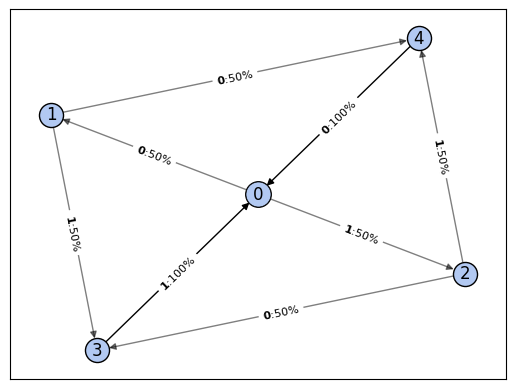

In [129]:
RRXOR = RRXORProcess()

# visualize the epsilon machine
graph = epsilon_machine_to_graph(RRXOR.T)
visualize_graph_with_selective_offset(graph, draw_mixed_state=True)

now let's compute the mixed state presentation and visualize it

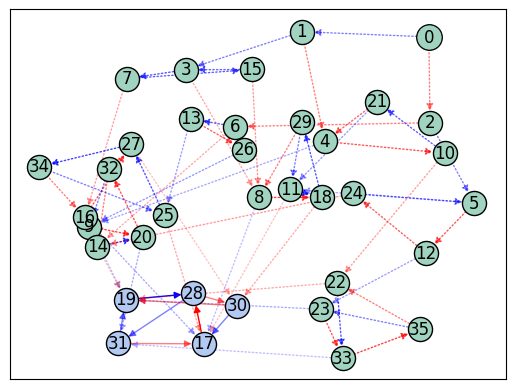

In [130]:
MSP = to_mixed_state_presentation(RRXOR.T, threshold=1e-5)
G_MSP = epsilon_machine_to_graph(MSP)
visualize_graph_with_selective_offset(G_MSP, layout='spring', draw_edge_labels=False, draw_mixed_state=True, draw_color=True)

now let's extract the recurrent part of the MSP, hopefully this should leave us with a HMM that is isomorphic to the original process

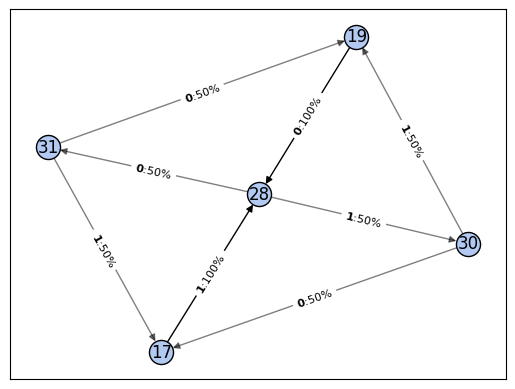

In [132]:
recurrent_subgraph = get_recurrent_subgraph(G_MSP)
visualize_graph_with_selective_offset(recurrent_subgraph,  draw_edge_labels=True, draw_mixed_state=True, draw_color=False)

plot the myopic entropy diagram

Text(0.5, 1.0, 'RRXOR Myopic Entropy')

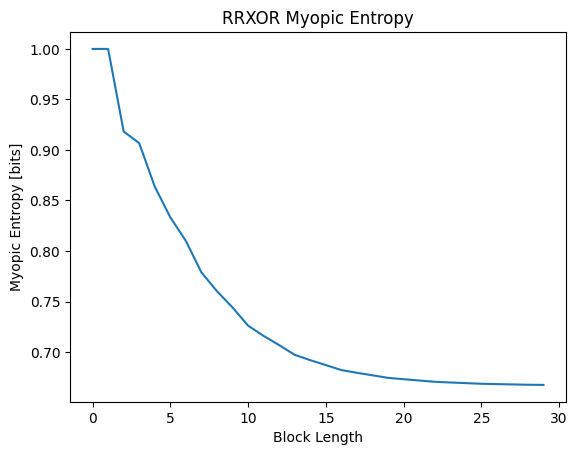

In [136]:
# myopic entropy
plt.plot(compute_myopic_entropy_from_MSP(MSP,30))
plt.ylabel('Myopic Entropy [bits]'); plt.xlabel('Block Length'); plt.title('RRXOR Myopic Entropy')

Now we will compute word distributions at different lengths

In [164]:
import pandas as pd
seq_probs = calculate_sequence_probabilities(RRXOR.T, 20)
data = []
for length, sequences in seq_probs.items():
    for sequence, probability in sequences.items():
        data.append({'length': length, 'sequence': sequence, 'probability': probability})

df = pd.DataFrame(data)
df.query('length == 2').sort_values('probability', ascending=False).head(10)

,length,sequence,probability
2,2,00,0.25
5,2,11,0.25
3,2,01,0.25
4,2,10,0.25


In [165]:
def calculate_probabilities(df, length):
    # Get the length and length + 1 data
    df_length = df[df['length'] == length]
    df_length_plus_one = df[df['length'] == length + 1]

    # Initialize a dictionary to store the probabilities
    probabilities = {'sequence': [], 'prob(0)': [], 'prob(1)': []}

    # For each length sequence
    for sequence in df_length['sequence']:
        # Get the probabilities of emitting a 0 or a 1 from the length + 1 data
        prob_0 = df_length_plus_one['probability'][df_length_plus_one['sequence'].str.startswith(sequence + '0')].sum()
        prob_1 = df_length_plus_one['probability'][df_length_plus_one['sequence'].str.startswith(sequence + '1')].sum()
        
        # Normalize the probabilities so they sum to 1
        total_prob = prob_0 + prob_1
        if total_prob > 0:
            prob_0 /= total_prob
            prob_1 /= total_prob
        
        # Add the probabilities to the dictionary
        probabilities['sequence'].append(sequence)
        probabilities['prob(0)'].append(prob_0)
        probabilities['prob(1)'].append(prob_1)

    # Convert the dictionary to a DataFrame
    df_new = pd.DataFrame(probabilities)
    #sort the dataframe by the probability of emitting a 0
    df_new = df_new.sort_values('prob(0)', ascending=False)
    return df_new

df_new = calculate_probabilities(df, 2)
df_new

,sequence,prob(0),prob(1)
0,00,0.666667,0.333333
3,11,0.666667,0.333333
1,01,0.333333,0.666667
2,10,0.333333,0.666667


[[[0.625 0.    0.    0.    0.    0.    0.    0.   ]
  [0.    0.    0.    0.625 0.    0.    0.    0.   ]
  [0.    0.    0.    0.    0.    0.    0.375 0.   ]
  [0.    0.    0.    0.    0.    0.    0.    0.375]
  [0.    0.    0.    0.    0.    0.    0.25  0.   ]
  [0.    0.    0.    0.75  0.    0.    0.    0.   ]
  [0.    0.    0.    0.    0.    0.    0.    0.25 ]
  [0.75  0.    0.    0.    0.    0.    0.    0.   ]]

 [[0.    0.    0.    0.    0.375 0.    0.    0.   ]
  [0.    0.    0.    0.    0.    0.375 0.    0.   ]
  [0.    0.625 0.    0.    0.    0.    0.    0.   ]
  [0.    0.    0.625 0.    0.    0.    0.    0.   ]
  [0.    0.75  0.    0.    0.    0.    0.    0.   ]
  [0.    0.    0.    0.    0.    0.25  0.    0.   ]
  [0.    0.    0.75  0.    0.    0.    0.    0.   ]
  [0.    0.    0.    0.    0.25  0.    0.    0.   ]]]


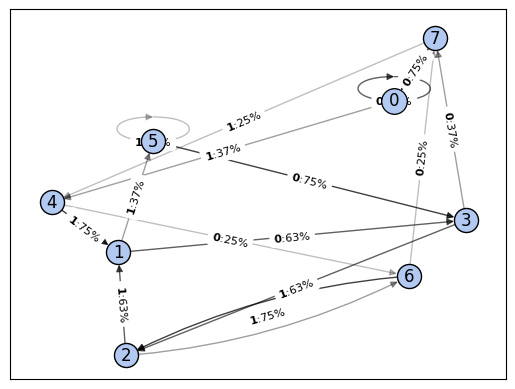

MSP has shape (2, 15, 15)


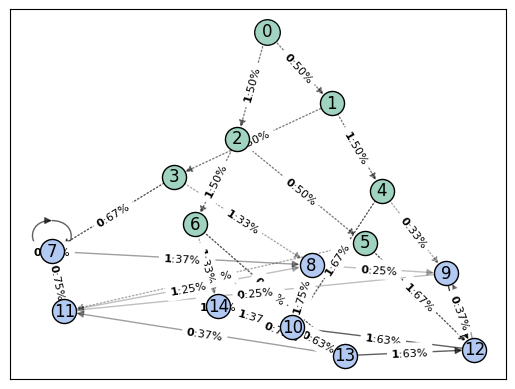

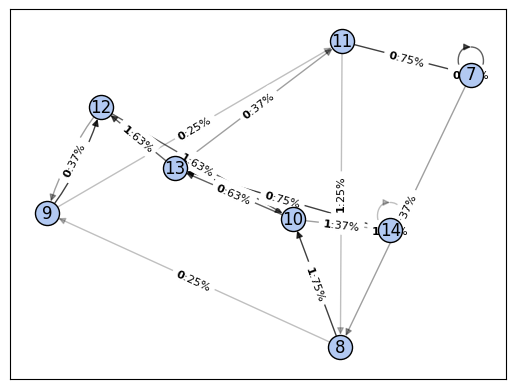

In [170]:
state_names, T, eprobs = create_transition_matrix(seq_probs, 3)
print(T)
G = epsilon_machine_to_graph(T)
visualize_graph_with_selective_offset(G, layout='spring', draw_edge_labels=True, draw_color=False, draw_mixed_state=True)
MSP = to_mixed_state_presentation(T, threshold=1e-5)
print("MSP has shape", MSP.shape)
G_MSP = epsilon_machine_to_graph(MSP)
visualize_graph_with_selective_offset(G_MSP, layout='spring', draw_edge_labels=True, draw_color=False, draw_mixed_state=True)
recur = get_recurrent_subgraph(G_MSP)
visualize_graph_with_selective_offset(recur, layout='spring', draw_edge_labels=True, draw_color=False, draw_mixed_state=True)

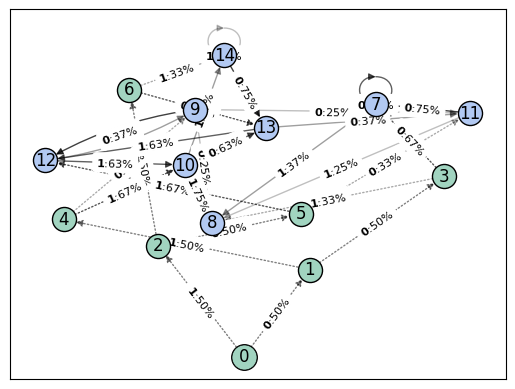

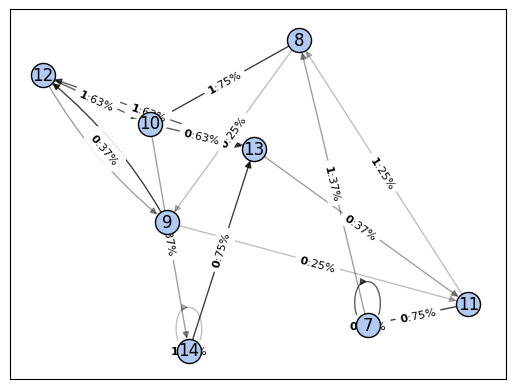

In [171]:
# make an MSP of the MSP
MSP_MSP = to_mixed_state_presentation(MSP, threshold=1e-5)
G_MSP_MSP = epsilon_machine_to_graph(MSP_MSP)
visualize_graph_with_selective_offset(G_MSP_MSP, layout='spring', draw_edge_labels=True, draw_color=False, draw_mixed_state=True)
# get recurrent
recurrent_subgraph = get_recurrent_subgraph(G_MSP_MSP)
visualize_graph_with_selective_offset(recurrent_subgraph, layout='spring', draw_edge_labels=True, draw_color=False, draw_mixed_state=True)

In [214]:
# Define a config for the transformer and training
config = {
    # transformer config
    'd_vocab': 2,
    'd_model': 16,
    'input_size': 3,  # context length
    'd_head': 16,
    'n_head': 4,
    'd_mlp': 4*16,
    'n_layers': 4,
    # training config
    'batch_size': 32,
    'sequence_length': 5000,
    'num_epochs': 1000,
    'learning_rate': 1.5e-2,
    'weight_decay': 0.0,
    'patience': 1000,
    'factor': 0.5
}

# Generate sequence data with positions
train_loader, test_loader, sequence_positions = RRXOR.prepare_data(config['sequence_length'], config['input_size'],
                                                                   split_ratio=0.8, batch_size=config['batch_size'],
                                                                   with_positions=True)

print(f"The number of batches in the training set is {len(train_loader)}")

# Model Definition
model = MultilayerTransformer(d_vocab=config['d_vocab'], d_model=config['d_model'], input_size=config['input_size'], 
                              d_head=config['d_head'], n_head=config['n_head'], d_mlp=config['d_mlp'], n_layers=config['n_layers'])
model.apply(initialize_weights)

# Check if CUDA is available and move the model to GPU if it is
if torch.cuda.is_available():
    model = model.cuda()
print('CUDA Available:', torch.cuda.is_available())

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=config['patience'], factor=config['factor'], verbose=True)

# Training
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=config['num_epochs'], verbose=True)

The number of batches in the training set is 125
CUDA Available: True
| Epoch | Training Acc. | Loss | Overall Acc. | Last Bit Acc. |
|   1   |    52.32%    |    0.6923     |      58.37%       |      56.05%      |
|   2   |    57.42%    |    0.6802     |      59.86%       |      63.28%      |
|   3   |    61.38%    |    0.6303     |      60.16%       |      67.97%      |
|   4   |    64.50%    |    0.6635     |      61.30%       |      64.55%      |
|   5   |    63.62%    |    0.7319     |      59.99%       |      64.84%      |
|   6   |    65.58%    |    0.6679     |      61.33%       |      68.55%      |
|   7   |    66.90%    |    0.6298     |      61.04%       |      67.68%      |
|   8   |    67.10%    |    0.6736     |      62.53%       |      67.97%      |
|   9   |    67.10%    |    0.6322     |      60.94%       |      67.68%      |
|  10   |    66.93%    |    0.5906     |      61.23%       |      67.09%      |
|  11   |    66.46%    |    0.6374     |      62.34%       |      

KeyboardInterrupt: 

## Golden Mean Process (4,3)

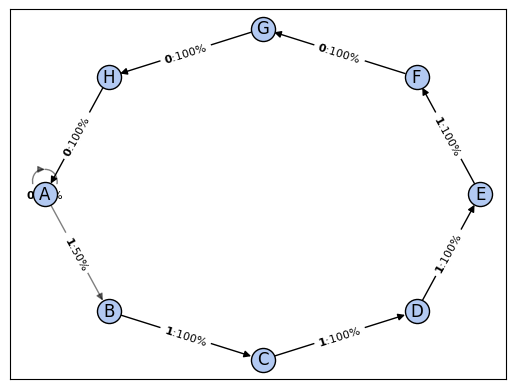

In [33]:
# visualize GM
GM = GoldenMeanProcess(5,3,0.5)
G = epsilon_machine_to_graph(GM.T, state_names=GM.state_names)
visualize_graph_with_selective_offset(G, layout='shell', draw_edge_labels=True, draw_color=False, draw_mixed_state=True)

MSP has shape (2, 15, 15)


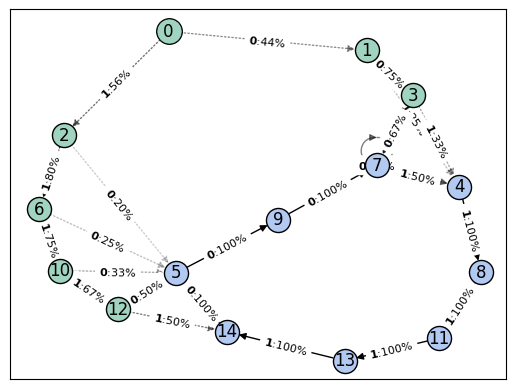

In [34]:
# visualize MSP of GM
# compute MSP of GM
MSP = to_mixed_state_presentation(GM.T, threshold=1e-5)
print("MSP has shape", MSP.shape)
G_MSP = epsilon_machine_to_graph(MSP)
visualize_graph_with_selective_offset(G_MSP, layout='spectral', draw_edge_labels=True, draw_color=False, draw_mixed_state=True)

[ 0.99107606  0.81127812  0.72192809  0.91829583 -0.         -0.
  0.81127812  1.         -0.         -0.          0.91829583 -0.
  1.         -0.         -0.        ]
(15, 15)


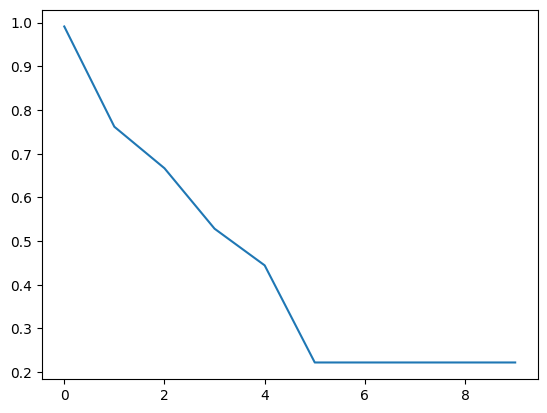

In [35]:
plt.plot(compute_myopic_entropy_from_MSP(MSP))

# 01R Process

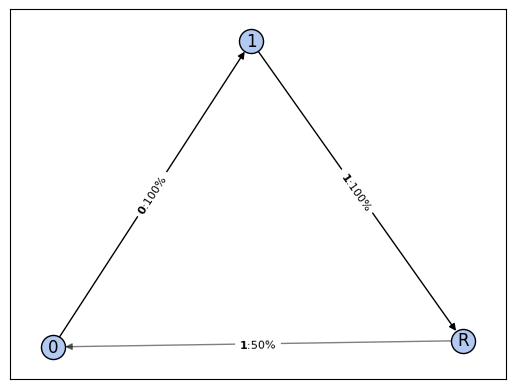

In [51]:
Z1R = ZeroOneRProcess()
G = epsilon_machine_to_graph(Z1R.T, state_names=Z1R.state_names)
# visualize
visualize_graph_with_selective_offset(G, layout='neato', draw_edge_labels=True, draw_color=False, draw_mixed_state=True)

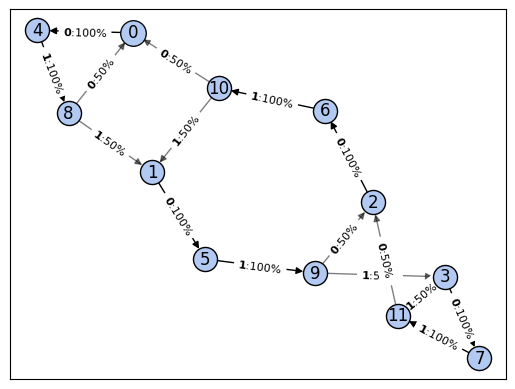

MSP has shape (2, 23, 23)


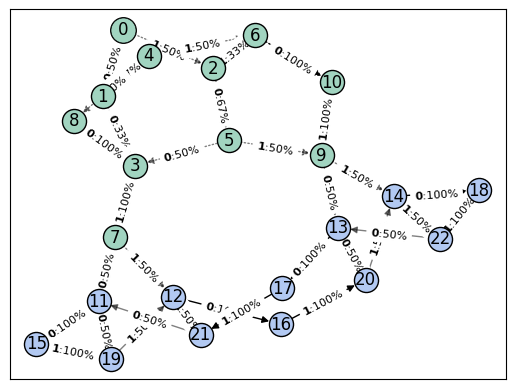

In [121]:
seq_probs = calculate_sequence_probabilities(Z1R.T, 7)
state_names, T, eprobs = create_transition_matrix(seq_probs, 6)
G = epsilon_machine_to_graph(T)
visualize_graph_with_selective_offset(G, layout='neato', draw_edge_labels=True, draw_color=False, draw_mixed_state=True)
MSP = to_mixed_state_presentation(T, threshold=1e-5)
print("MSP has shape", MSP.shape)
G_MSP = epsilon_machine_to_graph(MSP)
visualize_graph_with_selective_offset(G_MSP, layout='neato', draw_edge_labels=True, draw_color=False, draw_mixed_state=True)

In [82]:
seq = Z1R.generate(100000)
sequence_str = ''.join(map(str, seq))
print(sequence_str)
calculate_empirical_sequence_probabilities(sequence_str, 5)

1101101001001101101101101001101001101101001001001101101101101001001001101101101101001001101001101101101001001101101101101001101001001101001001101001001001101101101101001001101101101001101001001001101001101101101101101101101001001101101101001001001001001001101101001101001101001001101001001101001101001001101101101101101101001101001001001101101101001001001101001001001001101001101101101001101001001001001101001001101101001101001001001101001101101001101101001001101001001101001101101001001001101101101101001001101101101001001001001001101101001001001101001101001101101101001101101001101101001001001101101001001001001001101001001101101101101101001101001101001001001001001001001101101001101101101001101001001001101001001101001001001001101101101101101101001001001001001101101001101101101101001101001101101001101001101101101001001101101101101101001101001101101101001001101101001101101101001001001101101001101101001001101001101001001101101101001001001001101001001101101101001001101101101101101101101101101101

{1: {'1': 0.49911, '0': 0.50089},
 2: {'11': 0.16577165771657718,
  '10': 0.3333333333333333,
  '01': 0.3333333333333333,
  '00': 0.16756167561675617},
 3: {'110': 0.16577331546630933,
  '101': 0.16577331546630933,
  '011': 0.16576331526630533,
  '010': 0.16756335126702535,
  '100': 0.16756335126702535,
  '001': 0.16756335126702535},
 4: {'1101': 0.1657749732491975,
  '1011': 0.08199245977379321,
  '0110': 0.1657649729491885,
  '1010': 0.08378251347540426,
  '0100': 0.16756502695080852,
  '1001': 0.16756502695080852,
  '0010': 0.08378251347540426,
  '0011': 0.08377251317539526},
 5: {'11011': 0.08199327973118925,
  '10110': 0.08199327973118925,
  '01101': 0.16576663066522662,
  '11010': 0.08378335133405336,
  '10100': 0.08378335133405336,
  '01001': 0.16756670266810672,
  '10010': 0.08378335133405336,
  '00100': 0.08378335133405336,
  '10011': 0.08377335093403736,
  '00110': 0.08377335093403736}}

MSP has shape (2, 7, 7)


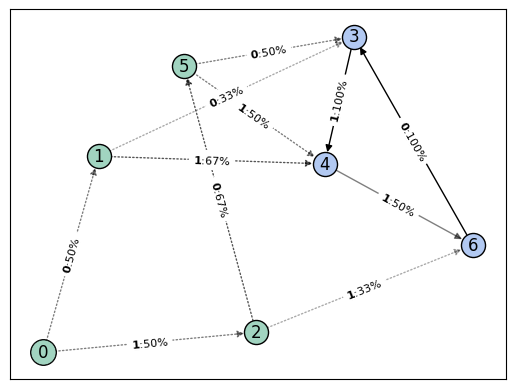

In [52]:
# get MSP
MSP = to_mixed_state_presentation(Z1R.T, threshold=1e-5)
print("MSP has shape", MSP.shape)
G_MSP = epsilon_machine_to_graph(MSP)
visualize_graph_with_selective_offset(G_MSP, layout='neato', draw_edge_labels=True, draw_color=False, draw_mixed_state=True)

In [221]:
# Define a config for the transformer and training
config = {
    # transformer config
    'd_vocab': 2,
    'd_model': 16,
    'input_size': 3,  # context length
    'd_head': 16,
    'n_head': 4,
    'd_mlp': 4*16,
    'n_layers': 4,
    # training config
    'batch_size': 32,
    'sequence_length': 5000,
    'num_epochs': 1000,
    'learning_rate': 1.5e-2,
    'weight_decay': 0.0,
    'patience': 1000,
    'factor': 0.5
}

# Generate sequence data with positions
train_loader, test_loader, sequence_positions = Z1R.prepare_data(config['sequence_length'], config['input_size'],
                                                                   split_ratio=0.8, batch_size=config['batch_size'],
                                                                   with_positions=True)

print(f"The number of batches in the training set is {len(train_loader)}")

# Model Definition
model = MultilayerTransformer(d_vocab=config['d_vocab'], d_model=config['d_model'], input_size=config['input_size'], 
                              d_head=config['d_head'], n_head=config['n_head'], d_mlp=config['d_mlp'], n_layers=config['n_layers'])
model.apply(initialize_weights)

# Check if CUDA is available and move the model to GPU if it is
if torch.cuda.is_available():
    model = model.cuda()
print('CUDA Available:', torch.cuda.is_available())

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=config['patience'], factor=config['factor'], verbose=True)

# Training
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=config['num_epochs'], verbose=True)

The number of batches in the training set is 125
CUDA Available: True
| Epoch | Training Acc. | Loss | Overall Acc. | Last Bit Acc. |
|   1   |    77.34%    |    0.5046     |      72.27%       |      83.59%      |
|   2   |    82.58%    |    0.6180     |      72.33%       |      84.08%      |
|   3   |    82.78%    |    0.4551     |      72.53%       |      84.08%      |
|   4   |    83.54%    |    0.4267     |      71.84%       |      82.71%      |
|   5   |    83.24%    |    0.4970     |      71.78%       |      82.42%      |
|   6   |    83.32%    |    0.4843     |      72.17%       |      83.01%      |
|   7   |    83.17%    |    0.4526     |      72.17%       |      82.52%      |
|   8   |    83.31%    |    0.4572     |      72.33%       |      83.59%      |
|   9   |    82.68%    |    0.4899     |      72.53%       |      84.38%      |
|  10   |    83.01%    |    0.4655     |      71.94%       |      83.30%      |
|  11   |    82.98%    |    0.4553     |      72.30%       |      

KeyboardInterrupt: 

[ 1.          0.91829583  0.91829583 -0.          1.          1.
 -0.        ]
(7, 7)


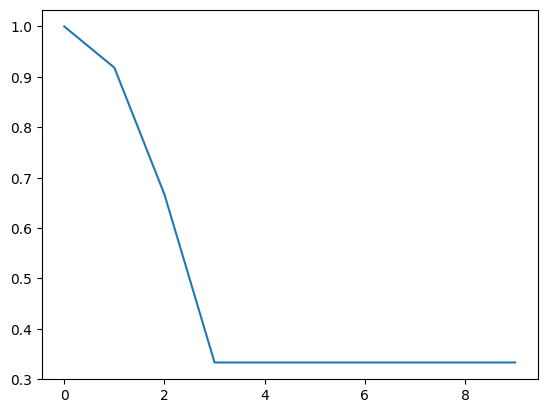

In [32]:
plt.plot(compute_myopic_entropy_from_MSP(MSP))

In [14]:
np.log(1)

0.0

# Even Process

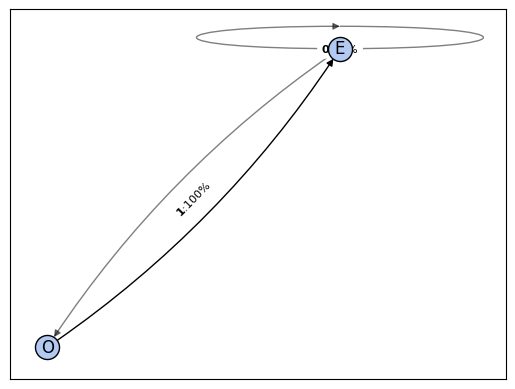

'[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1]'

In [108]:
even = EvenProcess(p=0.5)
G = epsilon_machine_to_graph(even.T, state_names=even.state_names)
visualize_graph_with_selective_offset(G,  draw_edge_labels=True, draw_color=False, draw_mixed_state=True)
''.join(str(even.generate(100)))

MSP has shape (2, 4, 4)


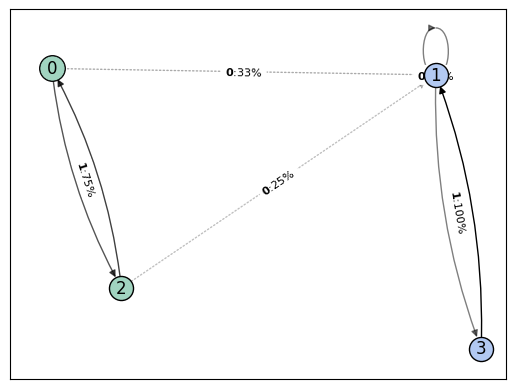

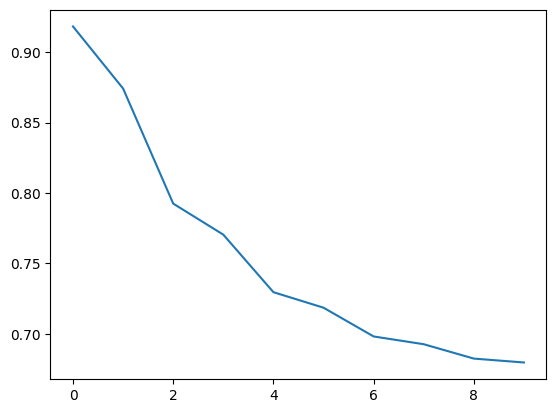

In [109]:
MSP = to_mixed_state_presentation(even.T, threshold=1e-5)
print("MSP has shape", MSP.shape)
G_MSP = epsilon_machine_to_graph(MSP)
visualize_graph_with_selective_offset(G_MSP,  draw_edge_labels=True, draw_color=False, draw_mixed_state=True)
plt.plot(compute_myopic_entropy_from_MSP(MSP))

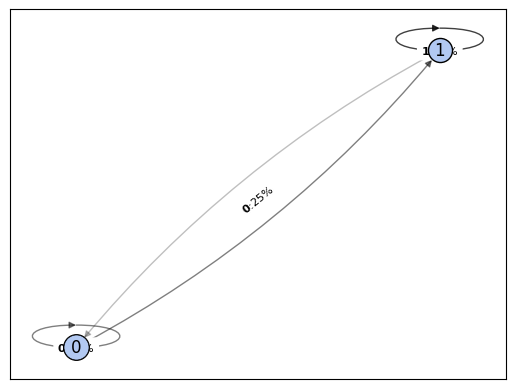

MSP has shape (2, 3, 3)


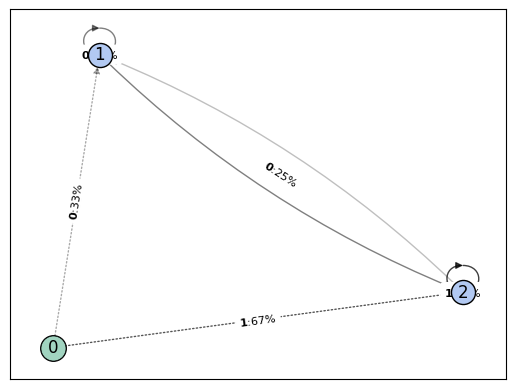

In [118]:
seq_probs = calculate_sequence_probabilities(even.T, 4)
state_names, T, eprobs = create_transition_matrix(seq_probs, 1)
G = epsilon_machine_to_graph(T)
visualize_graph_with_selective_offset(G, draw_edge_labels=True, draw_color=False, draw_mixed_state=True)
MSP = to_mixed_state_presentation(T, threshold=1e-5)
print("MSP has shape", MSP.shape)
G_MSP = epsilon_machine_to_graph(MSP)
visualize_graph_with_selective_offset(G_MSP,  draw_edge_labels=True, draw_color=False, draw_mixed_state=True)

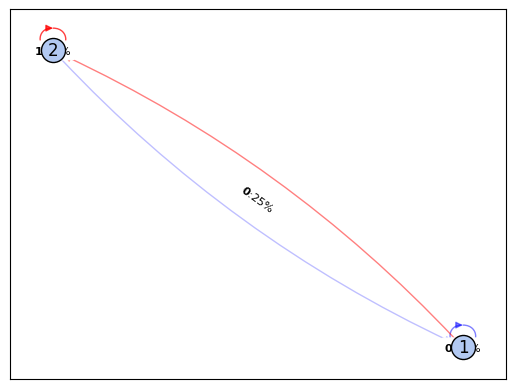

In [120]:
# get recurrent subgraph
G_recurrent = get_recurrent_subgraph(G_MSP)
visualize_graph_with_selective_offset(G_recurrent,  layout='spring', draw_edge_labels=True, draw_color=True, draw_mixed_state=True)